In [1]:
#libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


from sklearn.model_selection import validation_curve


# Tree print
from sklearn.tree import export_graphviz

# warnings
import warnings
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None  #hide any pandas warnings

sns.set(style="whitegrid", color_codes=True)

In [2]:
# Read data
file_name = 'heart_2.csv'
ds = pd.read_csv(file_name)

# Drop rows with thal equal to 0
ds.drop(ds[ds['thal'] == 0].index, axis=0, inplace=True)

In [3]:
# Columns rename
ds.columns = ['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'cholesterol', 'fasting_blood_sugar', 'rest_ecg', 'max_heart_rate_achieved',
       'exercise_induced_angina', 'st_depression', 'st_slope', 'num_major_vessels', 'thalassemia', 'target']

# Modifico i valori in modo da identificare con chiarezza le
# feature categoriche
ds['sex'][ds['sex'] == 0] = 'female'
ds['sex'][ds['sex'] == 1] = 'male'

ds['chest_pain_type'][ds['chest_pain_type'] == 0] = 'typical angina'
ds['chest_pain_type'][ds['chest_pain_type'] == 1] = 'atypical angina'
ds['chest_pain_type'][ds['chest_pain_type'] == 2] = 'non-anginal pain'
ds['chest_pain_type'][ds['chest_pain_type'] == 3] = 'asymptomatic'

ds['fasting_blood_sugar'][ds['fasting_blood_sugar'] == 0] = 'lower than 120mg/ml'
ds['fasting_blood_sugar'][ds['fasting_blood_sugar'] == 1] = 'greater than 120mg/ml'

ds['rest_ecg'][ds['rest_ecg'] == 0] = 'normal'
ds['rest_ecg'][ds['rest_ecg'] == 1] = 'ST-T wave abnormality'
ds['rest_ecg'][ds['rest_ecg'] == 2] = 'left ventricular hypertrophy'

ds['exercise_induced_angina'][ds['exercise_induced_angina'] == 0] = 'no'
ds['exercise_induced_angina'][ds['exercise_induced_angina'] == 1] = 'yes'

ds['st_slope'][ds['st_slope'] == 0] = 'upsloping'
ds['st_slope'][ds['st_slope'] == 1] = 'flat'
ds['st_slope'][ds['st_slope'] == 2] = 'downsloping'

ds['thalassemia'][ds['thalassemia'] == 1] = 'normal'
ds['thalassemia'][ds['thalassemia'] == 2] = 'fixed defect'
ds['thalassemia'][ds['thalassemia'] == 3] = 'reversable defect'


# Converto i tipi in modo corretto

ds['sex'] = ds['sex'].astype('object')
ds['chest_pain_type'] = ds['chest_pain_type'].astype('object')
ds['fasting_blood_sugar'] = ds['fasting_blood_sugar'].astype('object')
ds['rest_ecg'] = ds['rest_ecg'].astype('object')
ds['exercise_induced_angina'] = ds['exercise_induced_angina'].astype('object')
ds['st_slope'] = ds['st_slope'].astype('object')
ds['thalassemia'] = ds['thalassemia'].astype('object')

In [56]:
# Define confusion matrix function
def do_confusion_matrix(Y, prediction):
    cm = confusion_matrix(Y, prediction)
    cm_df = pd.DataFrame(cm)
    sns.heatmap(cm_df, annot=True, square=True, cmap="YlGnBu")
    plt.tight_layout()
    plt.show()
    print("Sensitivity (True Positives Rate):", np.round(cm[0,0]/(cm[0,0] + cm[1,0]), 2))
    print("Specificity (True Negatives Rate):", np.round(cm[1,1]/(cm[1,1] + cm[0,1]), 2))
    
# Define feature importance function
def do_feature_importance(model, x, y):
    model.fit(x, y)
    feature_importance = pd.DataFrame(model.feature_importances_, index=x.columns, columns=['RFC']).sort_values('RFC', ascending=False)

    sns.barplot(x=feature_importance.values[:,0], y=feature_importance.index, palette="deep")
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Features')
    plt.title("Visualizing Important Features")
    plt.show()
    model = None

In [50]:
# Dummy features
ds = pd.get_dummies(ds, drop_first=True)

In [8]:
# Split data in dataset and values to predict
X = ds.drop(['target'], axis=1) # X -> data
Y = ds['target'] # Y -> values to predict

In [9]:
# Normalizzo i dati
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
columns_names = X.columns
# Fit your data on the scaler object
X_scaled = X
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=columns_names)

In [10]:

X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size = 0.25, random_state = 50)
print("Train set:", np.round(X_train.shape[0]/X.shape[0]*100), "%", "({}/{})".format(X_train.shape[0], X.shape[0]))
print("Test set:", np.round(X_test.shape[0]/X.shape[0]*100), "%", "({}/{})".format(X_test.shape[0], X.shape[0]))

Train set: 75.0 % (763/1018)
Test set: 25.0 % (255/1018)


Accuracy Score (without Hyperparameters Tuning): 98.039%


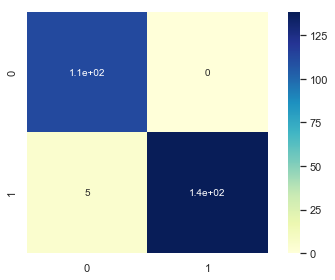

Sensitivity (True Positives Rate): 0.96
Specificity (True Negatives Rate): 1.0


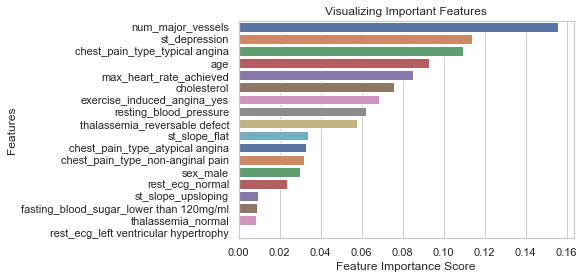

In [59]:
model = RandomForestClassifier(random_state=50)
model.fit(X_train, Y_train)
prediction = model.predict(X_test)
accuracy = accuracy_score(Y_test, prediction)
print("Accuracy Score (without Hyperparameters Tuning):", "{}%".format(np.round(100*accuracy,3)))
do_confusion_matrix(Y_test, prediction)

do_feature_importance(model, X_scaled, Y)

model = None
prediction = None
accuracy = None

In [17]:
max_features = list(range(1,X_scaled.shape[1]))
n_estimators = [2, 4, 8, 16, 32, 64, 100, 300]

hyperF = dict(n_estimators=n_estimators,
              max_features=max_features)

In [18]:
gridF = GridSearchCV(RandomForestClassifier(random_state=50), hyperF, cv = 10, verbose = 1, n_jobs = -1)
bestF = gridF.fit(X_train, Y_train)

Fitting 10 folds for each of 136 candidates, totalling 1360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 432 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 963 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1360 out of 1360 | elapsed:  1.5min finished


In [60]:
accuracyCV = cross_val_score(bestF, X_train, Y_train, cv = 10, scoring = 'accuracy')

print("Cross Validation Scores")
plt.plot(accuracyCV, '.-b', label="Accuracy CV")
plt.ylabel('Accuracy score')
plt.show()
print("CV Mean Accuracy Score:", np.round(np.mean(100*accuracyCV), 3), "%")
print()
print("*"*50)
print("\n\n")

Fitting 10 folds for each of 136 candidates, totalling 1360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    6.2s


KeyboardInterrupt: 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=64, n_jobs=None,
            oob_score=False, random_state=50, verbose=0, warm_start=False)
Accuracy Score (with Hyperparameters Tuning): 100.0%


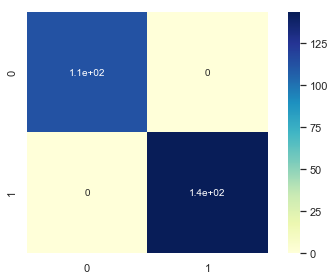

Sensitivity (True Positives Rate): 1.0
Specificity (True Negatives Rate): 1.0


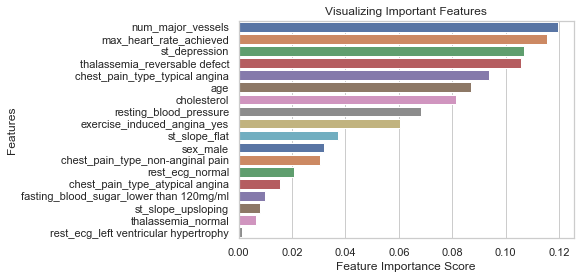

In [61]:
model = RandomForestClassifier(random_state=50, criterion='gini', n_estimators=bestF.best_estimator_.n_estimators,
              max_features=bestF.best_estimator_.max_features)

model = model.fit(X_train, Y_train)
prediction = model.predict(X_test)
accuracy = accuracy_score(Y_test, prediction)
#accuracyCV = cross_val_score(model, X_test, Y_test, cv = 10, scoring = 'accuracy')
#print(np.mean(accuracyCV))
#print("Accuracy Score (with Hyperparameters Tuning):", "{}%".format(np.round(100*accuracy,3)))
print(bestF.best_estimator_)

print("Accuracy Score (with Hyperparameters Tuning):", "{}%".format(np.round(100*accuracy,3)))

do_confusion_matrix(Y_test, prediction)
do_feature_importance(model, X_scaled, Y)

model = None
prediction = None
accuracy = None